In [38]:
import pandas as pd
import json
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import AutoTokenizer, DataCollatorWithPadding
import numpy as np
import evaluate
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

print(torch.has_mps)
device = torch.device('mps')

True


In [39]:
#### Set paths 

WORKING_DIR = os.getcwd()
DATA_DIR = "data"
full_path = os.path.join(WORKING_DIR, DATA_DIR)
print(full_path)

#### Load my dataset

train_df = pd.read_csv(os.path.join(full_path,"train_fine.csv"),sep='\t')
test_df = pd.read_csv(os.path.join(full_path,"test_fine.csv"), sep="\t")

/Users/melinaplakidis/Documents/DFKI/speech-act-classifier_LREC_COLING/data


In [40]:
### START PREPROCESSING 

labels = [i for i in train_df['labels'].values.tolist()]
unique_labels = set()

for lb in labels:
    if lb not in unique_labels:
        unique_labels.add(lb)
labels_to_ids = {k: v for v, k in enumerate(sorted(unique_labels))}
ids_to_labels = {v: k for v, k in enumerate(sorted(unique_labels))}

print(len(unique_labels))


17


In [41]:
### Fine uncased is the best performing model for fine-grained speech acts

def get_predictions(model_path):
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    predictions = []
    for text in tqdm(test_df["text"]):
        inputs = tokenizer(text, return_tensors="pt").to(device)
        model = AutoModelForSequenceClassification.from_pretrained(model_path, local_files_only=True).to(device)
        with torch.no_grad():
            logits = model(**inputs).logits
        predicted_class_id = logits.argmax().item()
        predicted_label = model.config.id2label[predicted_class_id]
        predictions.append(predicted_label)
    df_results = pd.DataFrame({"Text": test_df["text"], "True Label": test_df["labels"], "Prediction": predictions})
    texts, labels, predictions = [], [], []
    for text, label, prediction in zip(df_results["Text"], df_results["True Label"], df_results["Prediction"]):
        if label == prediction:
            continue
        else:
            texts.append(text)
            labels.append(label)
            predictions.append(prediction)
    errors = pd.DataFrame({"Text": texts, "True Label": labels, "Prediction": predictions})    
    print(errors)
    return errors

df_results = get_predictions("/Path/to/checkpoint-XY")

100%|██████████| 392/392 [05:33<00:00,  1.18it/s]

                                                  Text True Label Prediction
0    |LBR| Aber Deutschland wird Bunter und Bunter,...     UNSURE   COMPLAIN
1    Ich hab den Sibel Schick Schock, weil mich Sib...    SUSTAIN     ASSERT
2        Und das trotz so vieler Hashtags dieses Jahr.     UNSURE     ASSERT
3    |LBR| Die Völker müssen zeigen das sie diese S...    REQUEST    REQUIRE
4                        Die Muppet-Show im Bundestag.     ASSERT     UNSURE
..                                                 ...        ...        ...
103                            ohne dem geht es nicht.     UNSURE     ASSERT
104  Du bist als Muslima aber kein Ausdruck verschi...   EXCLUDED     ASSERT
105                             Interview mit Ragdahd.     ASSERT     UNSURE
106   |LBR| Nicht nur die May auch das Deutsche Volk..   COMPLAIN     ASSERT
107                     es traf ja nur die Nachbarn...   COMPLAIN     ASSERT

[108 rows x 3 columns]


In [42]:
df_results.to_csv("error_analysis/error_analysis_fine.csv")
cm = confusion_matrix(df_results["True Label"], df_results["Prediction"], labels=list(sorted(unique_labels)))

In [43]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(sorted(unique_labels)))

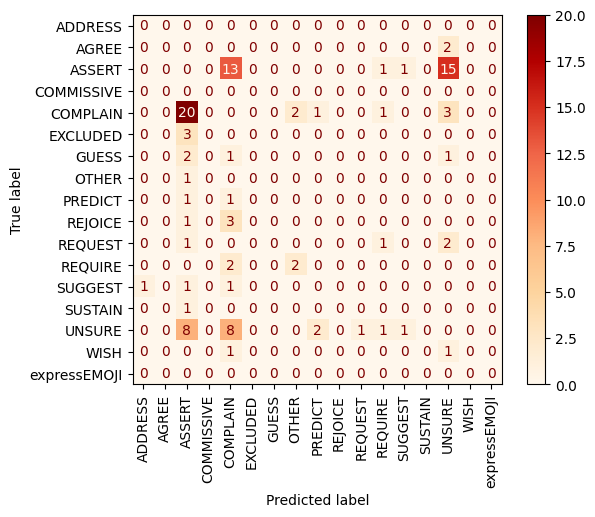

In [44]:
disp.plot(cmap = "OrRd", xticks_rotation=90)
plt.show()